In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import struct
import pandas as pd
import scipy
from scipy.signal import find_peaks
from matplotlib import colors
from matplotlib import ticker
import matplotlib as mpl
import requests, zipfile
import io
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.fft import fft, fftfreq

**To extract other runs:**

Check the following link: https://docs.google.com/spreadsheets/d/1M0jMwS33TttGbs-REGRAopI9uiohMjcxCvUPJjYtd2g/edit?gid=1816173087#gid=1816173087

To find the run files you wish to extract.

Then, log into a DUNE machine. Instruction for how to do it and extract runs are at the bottom of this page.

# Plan:

datn - neutron source active

datc - cosmics only

data (X) - datn + datc

label (y) - 1 for datn and 0 for datc

X -> transform to features

train test split

run a model - classifier using sklearn

fit - train

evaluate on test

Next Steps:

- Run on different segments of data: try to understand if the classification works well for outlayers too.

- Try different features

- Try different models - random forest, SVM with RBF kernek, ensemble methods and so on.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')


In [3]:
def substract_peds(row):
    return row - np.argmax(np.bincount(row))

In [4]:
# filename2 = '/content/drive/MyDrive/lab_adi/adc_data_run_25087_ch_37_all.npy'
# cdata = cp.load(filename2, mmap_mode='r').astype(cp.int16)

# filename3 = '/content/drive/MyDrive/lab_adi/adc_data_run_25050_ch_37_all.npy'
# ndata = cp.load(filename3, mmap_mode='r').astype(cp.int16)



In [5]:
from scipy.signal import find_peaks
import gc

def filter_rows(data, param, threshold=0, window_size=0):
  print(data.shape[0])
  print(data.shape[1])
  filtered_data = []
  peak_data = []
  for row in data:
      row = substract_peds(row)
      if 400 < np.max(row) < 12.5e3:
          filtered_data.append(row)
  filtered_data = np.array(filtered_data)
  print(filtered_data.shape[0])
  print(filtered_data.shape[1])
  del data
  gc.collect()
  for row in filtered_data:
    if param == 1:
      index_range = slice(100, 1900)
      peaks, _ = find_peaks(row[index_range], height=100)
      peaks = peaks + index_range.start
    else:
      index_range = slice(100, 52000)
      peaks, _ = find_peaks(row[index_range], height=100)
      peaks = peaks + index_range.start
    print(len(peaks))
    for i, peak in enumerate(peaks):
      if peak in (0, len(row) - 1) or (i > 0 and peaks[i - 1] == peak - 1) or (i < len(peaks) - 1 and peaks[i + 1] == peak + 1):
        continue
      threshold = 0.1 * row[peak]
      left_edge_ind = peak
      while left_edge_ind > max(0, peak-100) and row[left_edge_ind] > threshold:
        left_edge_ind -= 1
      right_edge_ind = peak
      while right_edge_ind < min(len(row)-1, peak+100) and row[right_edge_ind] > threshold:
        right_edge_ind += 1
      if row[left_edge_ind] <= threshold and row[right_edge_ind] <= threshold:
        peak_data.append(row[left_edge_ind:right_edge_ind])
  print(len(peak_data))
  del filtered_data
  gc.collect()
  return peak_data

In [6]:
def load_in_chunks(filename, chunk_size, param, upper_limit = None):
    data = np.load(filename, mmap_mode='r').astype(np.int16)
    data[data < 0] = 0
    data = filter_rows(data, param)
    plt.plot(data[0])
    plt.show()
    plt.plot(data[40])
    plt.show()
    plt.plot(data[50])
    plt.show()
    plt.plot(data[70])
    plt.show()
    total_size = len(data)
    for start in range(0, total_size, chunk_size):
        end = min(start + chunk_size, total_size) if upper_limit is None else min(start + chunk_size, upper_limit, total_size)
        chunk = pd.DataFrame(data[start:end])
        chunk = chunk[(chunk != 0).any(axis=1)]
        if not chunk.empty:
            yield chunk

In [7]:
# !pip install ipdb
import ipdb
from scipy.signal import find_peaks, chirp, peak_widths

def prompt_fraction(data):
    prompt_fraction = []
    all_values = []
    for i in range(len(data)):
        signal = data[i][~np.isnan(data[i])]
        peak_index = np.argmax(signal)
        width = peak_widths(signal, [peak_index], rel_height=0.35)[0]
        eall = len(signal)
        bprompt = np.argmax(np.gradient(signal))
        endprompt = int(peak_index + width[0]/ 2)
        endprompt = min(endprompt, eall - 1)
        pr = signal[bprompt:endprompt]
        pr = pr[pr > 0]
        ali = signal[bprompt:eall]
        ali = ali[ali > 0]
        prompt_fraction.append(np.sum(pr) / np.sum(ali))
        all_values.append(np.sum(ali))
        if np.sum(pr) / np.sum(ali) == 1:
          plt.plot(data[i])
          plt.show()
          ipdb. set_trace()

    return np.array(prompt_fraction), np.array(all_values)

In [8]:
from scipy.signal import find_peaks, chirp, peak_widths

def prompt_fraction_around_peak(data):
    prompt_fraction = []
    all_values = []
    for row in data:
        row = row[~np.isnan(row)]
        eall = len(row)
        peak_index = np.argmax(row)
        rising_edge = np.argmax(np.gradient(row))
        width = peak_widths(row, [peak_index], rel_height=0.3)[0]
        l = (width[0] / 2).astype(int)
        #l = ((peak_index-rising_edge) / 2).astype(int)
        bprompt = max(0, peak_index - l)
        endprompt = min(eall, peak_index + l)
        pr = row[bprompt:endprompt]
        pr = pr[pr > 0]

        ali = row[0:eall]
        ali = ali[ali > 0]

        prompt_fraction.append(np.sum(pr) / np.sum(ali))
        all_values.append(np.sum(ali))

    return np.array(prompt_fraction), all_values

In [9]:

def prompt_fraction_v(data, r1):
    prompt_fraction = []
    all = []

    for i in range(len(data)):
        signal = data[i][~np.isnan(data[i])]
        rising_edge = np.argmax(np.gradient(signal))
        bprompt, endprompt  = rising_edge+10, rising_edge+ r1
        eall = len(signal)
        pr = signal[bprompt:endprompt]
        pr = pr[pr > 0]
        ali = signal[bprompt:eall]
        ali = ali[ali > 0]
        prompt_fraction.append( np.sum(pr)/ np.sum(ali))
        all.append(np.sum(ali))


    return np.array(prompt_fraction), np.array(all)

In [10]:
from sklearn.utils import resample

def Bootstrap(data):
    n_iterations = len(data)
    sample_size = len(data)
    bootstrapped_variances = []
    for i in range(n_iterations):
        sample = resample(data, n_samples=sample_size)
        sample_variance = np.var(sample, ddof=1)
        bootstrapped_variances.append(sample_variance)
    bootstrapped_variances = np.array(bootstrapped_variances)
    return bootstrapped_variances

In [11]:
def features_extraction(df):
    # From all these features, the ones actually used were only the first 3.
    # We should test whether the classification works better with other set of parameters, from the following or others.
    X = df.values
    PromptFraction = prompt_fraction(X)[0]
    PeakPrompt = prompt_fraction_around_peak(X)[0]
    vPrompt = prompt_fraction_v(X, 50)[0]

    PromptFraction_Peak_Dif = PromptFraction - PeakPrompt
    PromptFraction_vPrompt_Dif = PromptFraction - vPrompt
    Peak_vPrompt_Dif = PeakPrompt - vPrompt

    PromptFraction_Peak_Plus = PromptFraction + PeakPrompt
    PromptFraction_vPrompt_Plus = PromptFraction + vPrompt
    Peak_vPrompt_Plus = PeakPrompt + vPrompt

    PromptFraction_Var = Bootstrap(PromptFraction)
    Peak_Var = Bootstrap(PeakPrompt)
    vPrompt_Var = Bootstrap(vPrompt)

    PromptFraction_Peak_Mult = PromptFraction*PeakPrompt
    PromptFraction_vPrompt_Mult = PromptFraction*vPrompt
    Peak_vPrompt_Mult = PeakPrompt*vPrompt

    PromptFraction_2 = PromptFraction*PromptFraction
    PeakPrompt_2 = PeakPrompt*PeakPrompt
    Promptv_2 = vPrompt*vPrompt

    PromptFraction_3 = PromptFraction**3
    PeakPrompt_3 = PeakPrompt**3
    Promptv_3 = vPrompt**3

    Diff_All = -PromptFraction -PeakPrompt -vPrompt
    Plus_All = PromptFraction + PeakPrompt + vPrompt
    Mult_All = PromptFraction*PeakPrompt*vPrompt

    #Create dataframe from features

    data = {
    'PromptFraction': PromptFraction,
    'PeakPrompt': PeakPrompt,
    'V_PROMPT': vPrompt,
    'PromptFraction_Peak_Dif': PromptFraction_Peak_Dif,
    'PromptFraction_vPrompt_Dif': PromptFraction_vPrompt_Dif,
    'Peak_vPrompt_Dif': Peak_vPrompt_Dif,
    'PromptFraction_Var': PromptFraction_Var,
    'vPrompt_Var': vPrompt_Var,
    'Peak_Var': Peak_Var,
    'PromptFraction_Peak_Plus': PromptFraction_Peak_Plus,
    'PromptFraction_vPrompt_Plus': PromptFraction_vPrompt_Plus,
    'Peak_vPrompt_Plus': Peak_vPrompt_Plus,
    'PromptFraction_Peak_Mult': PromptFraction_Peak_Mult,
    'PromptFraction_vPrompt_Mult': PromptFraction_vPrompt_Mult,
    'Peak_vPrompt_Mult': Peak_vPrompt_Mult,
    'PromptFraction_2': PromptFraction_2,
    'PeakPrompt_2': PeakPrompt_2,
    'Promptv_2': Promptv_2,
    'Diff_All': Diff_All,
    'Plus_All': Plus_All,
    'Mult_All': Mult_All,
    'PromptFraction_3': PromptFraction_3,
    'PeakPrompt_3': PeakPrompt_3,
    'Promptv_3': Promptv_3
    }
    # Create a DataFrame
    df_features = pd.DataFrame(data)
    return df_features

In [14]:
# # filename = '/content/drive/MyDrive/lab_adi/adc_data_run_25036_ch_40_all.npy'
# folder_base = '../../coldbox_data'
# filename = f'{folder_base}/adc_data_run_25036_ch_40_all.npy'
# chunk_size = 500
# threshold = 100
# num_columns = 1150
# window_size = 500
# # output_file = '/content/drive/MyDrive/lab_adi/processed_data_positive.csv'
# output_file = f'{folder_base}/processed_data_positive.csv'

# with open(output_file, 'w') as f:
#     pd.DataFrame().to_csv(f, index=False)

# for i, chunk in enumerate(load_in_chunks(filename, chunk_size, 1, None)):
#     processed_chunk = features_extraction(chunk)
#     # print(processed_chunk.shape)
#     if i == 0:
#         processed_chunk.to_csv(output_file, mode='a', header=True, index=False)
#     else:
#         processed_chunk.to_csv(output_file, mode='a', header=False, index=False)


In [16]:
# # filename = '/content/drive/MyDrive/lab_adi/adc_data_run_25066_ch_40_all.npy'
# filename = f'{folder_base}/adc_data_run_25066_ch_40_all.npy'
# chunk_size = 500
# num_columns = 1150
# threshold = 100
# window_size = 500
# # output_file = '/content/drive/MyDrive/lab_adi/processed_data_negative.csv'
# output_file = f'{folder_base}/processed_data_negative.csv'

# with open(output_file, 'w') as f:
#     pd.DataFrame().to_csv(f, index=False)

# for i, chunk in enumerate(load_in_chunks(filename, chunk_size, 0, None)):
#     processed_chunk = features_extraction(chunk)
#     # print(processed_chunk.shape)
#     if i == 0:
#         processed_chunk.to_csv(output_file, mode='a', header=True, index=False)
#     else:
#         processed_chunk.to_csv(output_file, mode='a', header=False, index=False)

In [14]:
# filename = '/content/drive/MyDrive/lab_adi/adc_data_run_25071_ch_37_all.npy'
# chunk_size = 500
# num_columns = 1150
# threshold = 100
# window_size = 300
# output_file = '/content/drive/MyDrive/lab_adi/processed_data_positive.csv'

# for i, chunk in enumerate(load_in_chunks(filename, chunk_size, 1, None)):
#     processed_chunk = features_extraction(chunk)
#     print(processed_chunk.shape)
#     processed_chunk.to_csv(output_file, mode='a', header=False, index=False)

In [15]:
# filename = '/content/drive/MyDrive/lab_adi/adc_data_run_25050_ch_37_all.npy'
# chunk_size = 500
# num_columns = 65536
# upper_limit = 4200
# output_file = '/content/drive/MyDrive/lab_adi/processed_data_positive.csv'

# for i, chunk in enumerate(load_in_chunks(filename, chunk_size, 1500, upper_limit)):
#     processed_chunk = features_extraction(chunk)
#     print(processed_chunk.shape)
#     processed_chunk.to_csv(output_file, mode='a', header=False, index=False)

In [16]:
# filename = '/content/drive/MyDrive/lab_adi/adc_data_run_25087_ch_37_all.npy'
# chunk_size = 500
# num_columns = 1150
# threshold = 100
# window_size = 300
# output_file = '/content/drive/MyDrive/lab_adi/processed_data_negative.csv'

# for i, chunk in enumerate(load_in_chunks(filename, chunk_size, 0, None)):
#     processed_chunk = features_extraction(chunk)
#     print(processed_chunk.shape)
#     processed_chunk.to_csv(output_file, mode='a', header=False, index=False)

In [17]:
folder_base = '../../coldbox_data'
output_file_pos = f'{folder_base}/processed_data_positive.csv'
output_file_neg = f'{folder_base}/processed_data_negative.csv'

positive_df_features = pd.read_csv(output_file_pos).fillna(0)
negative_df_features = pd.read_csv(output_file_neg).fillna(0)

print(positive_df_features.shape)
print(negative_df_features.shape)

(73146, 24)
(69346, 24)


In [18]:
negative_df_features = negative_df_features.iloc[0:positive_df_features.shape[0],:]
print(positive_df_features.shape)
print(negative_df_features.shape)

(73146, 24)
(69346, 24)


In [19]:
positive_df_features = positive_df_features.drop([ 'Diff_All',
    'Plus_All', 'Mult_All'], axis=1)
negative_df_features = negative_df_features.drop([ 'Diff_All',
    'Plus_All', 'Mult_All'], axis=1)
positive_df_features = positive_df_features.drop([ 'Promptv_3',
    'PromptFraction_3', 'PeakPrompt_3'], axis=1)
negative_df_features = negative_df_features.drop([ 'Promptv_3',
    'PromptFraction_3', 'PeakPrompt_3'], axis=1)
positive_df_features = positive_df_features.drop([ 'Promptv_2',
    'PromptFraction_2', 'PeakPrompt_2'], axis=1)
negative_df_features = negative_df_features.drop([ 'Promptv_2',
    'PromptFraction_2', 'PeakPrompt_2'], axis=1)
negative_df_features = negative_df_features.drop([ 'PromptFraction_Peak_Dif',
    'PromptFraction_vPrompt_Dif', 'Peak_vPrompt_Dif'], axis=1)
positive_df_features = positive_df_features.drop([ 'PromptFraction_Peak_Dif',
    'PromptFraction_vPrompt_Dif', 'Peak_vPrompt_Dif'], axis=1)
# negative_df_features = negative_df_features.drop([ 'PromptFraction',
#     'PeakPrompt', 'V_PROMPT'], axis=1)
# positive_df_features = positive_df_features.drop([ 'PromptFraction',
#     'PeakPrompt', 'V_PROMPT'], axis=1)
negative_df_features = negative_df_features.drop([ 'PromptFraction_Peak_Plus',
    'PromptFraction_vPrompt_Plus', 'Peak_vPrompt_Plus'], axis=1)
positive_df_features = positive_df_features.drop([ 'PromptFraction_Peak_Plus',
    'PromptFraction_vPrompt_Plus', 'Peak_vPrompt_Plus'], axis=1)
negative_df_features = negative_df_features.drop([ 'PromptFraction_Var',
    'vPrompt_Var', 'Peak_Var'], axis=1)
positive_df_features = positive_df_features.drop([ 'PromptFraction_Var',
    'vPrompt_Var', 'Peak_Var'], axis=1)
negative_df_features = negative_df_features.drop([ 'PromptFraction_Peak_Mult', 'PromptFraction_vPrompt_Mult', 'Peak_vPrompt_Mult'], axis=1)
positive_df_features = positive_df_features.drop([ 'PromptFraction_Peak_Mult',
     'PromptFraction_vPrompt_Mult', 'Peak_vPrompt_Mult'], axis=1)

In [20]:
X = np.concatenate((positive_df_features.values, negative_df_features.values), axis=0)
y = np.array([1]*len(positive_df_features) + [0]*len(negative_df_features))

In [21]:
print(f"X.shape={X.shape}")
print(f"y.shape={y.shape}")

X.shape=(142492, 3)
y.shape=(142492,)


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [23]:
print(f"len positive = {len(positive_df_features)}")
print(f"len negative = {len(negative_df_features)}")

len positive = 73146
len negative = 69346


In [24]:
def Train(max_depth, min_samples):
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

  # Initialize the classifier
  clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split = min_samples, min_samples_leaf=min_samples)

  # Train the classifier
  clf.fit(X_train, y_train)

  # Make predictions
  y_pred = clf.predict(X_test)

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)

  #report = classification_report(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  return accuracy, recall, f1, precision

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

tree_depths = np.arange(5, 71)
min_samples_splits_leaf = np.arange(2, 21)

xaxis, yaxis = np.meshgrid(tree_depths, min_samples_splits_leaf)

accuracy_vals = np.zeros_like(xaxis, dtype=float)
recall_vals = np.zeros_like(xaxis, dtype=float)
f1_vals = np.zeros_like(xaxis, dtype=float)
precision_vals = np.zeros_like(xaxis, dtype=float)

for i in range(xaxis.shape[0]):
    for j in range(xaxis.shape[1]):
        # print(Train(xaxis[i, j], yaxis[i, j]))
        accuracy_vals[i, j], recall_vals[i,j], f1_vals[i,j], precision_vals[i,j]= Train(xaxis[i, j], yaxis[i, j])

fig = plt.figure(figsize=(10, 12))
fig.suptitle("Accuracy and F1 vs. Tree Depth and Minimum Samples", fontsize=15)
ax1 = fig.add_subplot(211, projection='3d')
scatter1 = ax1.scatter(xaxis, yaxis, accuracy_vals, c=accuracy_vals, cmap='viridis', s=1)
cbar1 = fig.colorbar(scatter1, ax=ax1, pad=0.1)
cbar1.set_label('Accuracy')
ax1.set_xlabel('Maximum tree depth')
ax1.set_ylabel('Minimum Samples per Leaf and Split')
ax1.set_zlabel('Accuracy')
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(212, projection='3d')
scatter2 = ax2.scatter(xaxis, yaxis, f1_vals, c=f1_vals, cmap='viridis', s=1)
cbar2 = fig.colorbar(scatter2, ax=ax2, pad=0.1)
cbar2.set_label('F1')
ax1.set_xlabel('Maximum tree depth')
ax1.set_ylabel('Minimum Samples per Leaf and Split')
ax1.set_zlabel('F1')
ax2.set_title('F1')

plt.subplots_adjust(hspace=0.61)
plt.subplots_adjust(wspace=0.61)
plt.show()

fig2 = plt.figure(figsize=(10, 12))
fig2.suptitle("Precision and Recall vs. Tree Depth and Minimum Samples", fontsize=15)
ax3 = fig2.add_subplot(211, projection='3d')
scatter3 = ax3.scatter(xaxis, yaxis, recall_vals, c=recall_vals, cmap='viridis', s=1)
cbar3 = fig2.colorbar(scatter3, ax=ax3, pad=0.1)
cbar3.set_label('Recall')
ax3.set_xlabel('Maximum tree depth')
ax3.set_ylabel('Minimum Samples per Leaf and Split')
ax3.set_zlabel('Recall')
ax3.set_title('Recall')

ax4 = fig2.add_subplot(212, projection='3d')
scatter4 = ax4.scatter(xaxis, yaxis, precision_vals, c=precision_vals, cmap='viridis', s=1)
cbar2 = fig2.colorbar(scatter4, ax=ax4, pad=0.1)
cbar2.set_label('Precision')
ax1.set_xlabel('Maximum tree depth')
ax1.set_ylabel('Minimum Samples per Leaf and Split')
ax1.set_zlabel('Precision')
ax2.set_title('Precision')

plt.subplots_adjust(hspace=0.61)
plt.subplots_adjust(wspace=0.61)
plt.show()

(0.5708805090296623, 0.7540886789024168, 0.6440960769857592, 0.5621063325431764)
(0.5650088893047628, 0.572972972972973, 0.575679437738174, 0.5784115920763023)
(0.5771498081781604, 0.6927826564215148, 0.6262972917097375, 0.5714555195050177)
(0.5797464208851876, 0.6876553438276719, 0.6245166684084021, 0.5719973965312608)
(0.5940862730420137, 0.6983440997179511, 0.638906230490698, 0.588792574409328)
(0.5965893141199589, 0.7311571611956721, 0.6490710404753668, 0.5835559295985949)
(0.6058295124918125, 0.7701592546697875, 0.6657541855113862, 0.586276770429375)
(0.631304388509404, 0.7597628851984253, 0.6805699114326828, 0.6163277292416122)
(0.6449424534481145, 0.7115942028985507, 0.674305823784387, 0.6407307723676698)
(0.656124263123421, 0.7371880314381578, 0.6857497114027962, 0.6410215419048)
(0.6737157293908487, 0.7613032217021857, 0.7060856372218476, 0.6583362804039451)
(0.7069102648077104, 0.7856815473462279, 0.7323606690449235, 0.6858171634326865)
(0.7254374473659586, 0.7745142545850735

KeyboardInterrupt: 

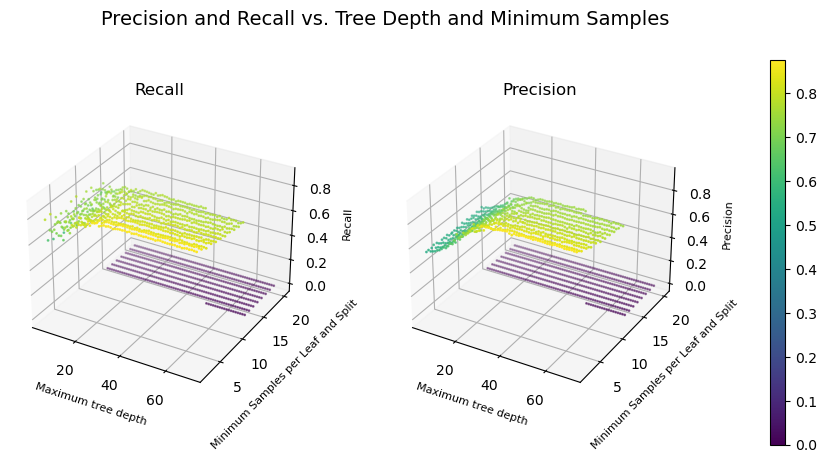

In [26]:
import matplotlib.gridspec as gridspec

gs2 = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05])

fig2 = plt.figure(figsize=(10, 5))
fig2.suptitle("Precision and Recall vs. Tree Depth and Minimum Samples", fontsize=14)
ax3 = fig2.add_subplot(gs2[0], projection='3d')
sc3 = ax3.scatter(xaxis, yaxis, recall_vals, c=recall_vals, cmap='viridis', s=1)
ax3.set_xlabel('Maximum tree depth', fontsize=8)
ax3.set_ylabel('Minimum Samples per Leaf and Split', fontsize=8)
ax3.set_zlabel('Recall', fontsize=8)
ax3.set_title('Recall')

ax4 = fig2.add_subplot(gs2[1], projection='3d')
scatter4 = ax4.scatter(xaxis, yaxis, precision_vals, c=precision_vals, cmap='viridis', s=1)
ax4.set_xlabel('Maximum tree depth', fontsize=8)
ax4.set_ylabel('Minimum Samples per Leaf and Split', fontsize=8)
ax4.set_zlabel('Precision', fontsize=8)
ax4.set_title('Precision')

cbar_ax = fig2.add_subplot(gs2[2])
fig2.colorbar(sc3, cax=cbar_ax)

plt.subplots_adjust(wspace=0.4)  # Adjust the space between plots
plt.show()


In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

# Initialize the classifier
clf = DecisionTreeClassifier(max_depth=30)
clf.fit(X_train, y_train)

# Make predictions
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Classification Report:\n", report)

NameError: name 'y_pred' is not defined

In [28]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

NameError: name 'y_pred' is not defined

Feature: $F_{p}$ by Peak Width, Importance: 0.3346388890093305
Feature: $F_{p}$ Around Maxima, Importance: 0.3402633985283561
Feature: $F_{p}$ by Predifined Margins, Importance: 0.3250977124623135


NameError: name 'y_pred' is not defined

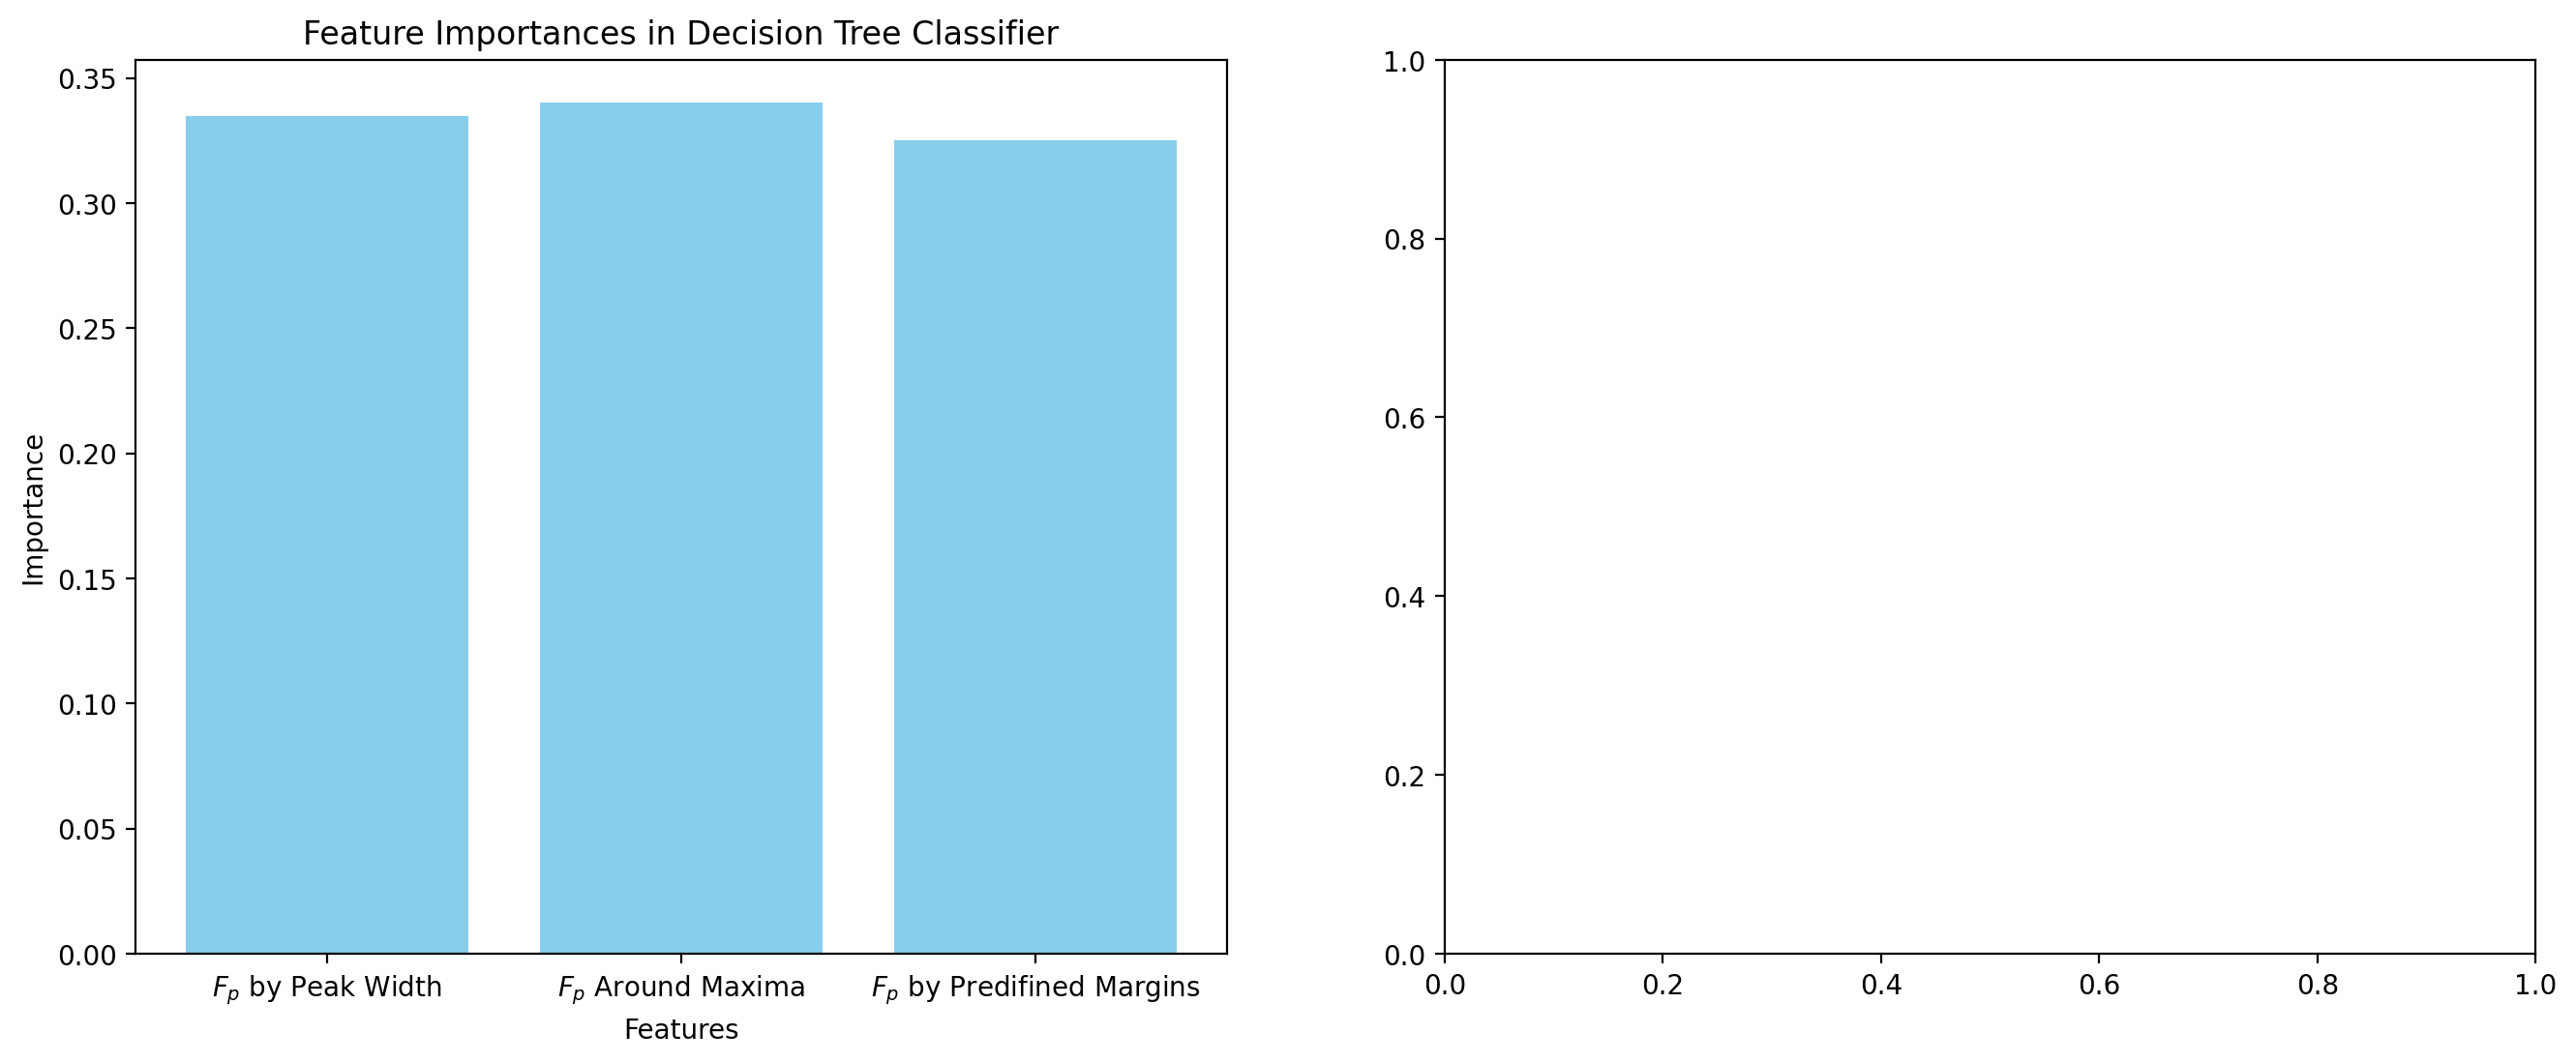

In [29]:
# Get feature importances
feature_importances = clf.feature_importances_
feature_names = ['$F_{p}$ by Peak Width', '$F_{p}$ Around Maxima', '$F_{p}$ by Predifined Margins']
# Print feature importances
for feature, importance in zip(feature_names, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")

# Optionally, plot the feature importances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 6], dpi=200)

ax1.bar(feature_names, feature_importances, color='skyblue')
ax1.set_xlabel('Features')
ax1.set_ylabel('Importance')
ax1.set_title('Feature Importances in Decision Tree Classifier')

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot(ax=ax2)
ax2.set_title("Confusion Matrix")
plt.show()


In [30]:
data = {'X': np.concatenate([positive_df_features['PromptFraction'].values, negative_df_features['PromptFraction'].values]),
        'Y': np.concatenate([positive_df_features['PeakPrompt'].values, negative_df_features['PeakPrompt'].values]),
        'Z': np.concatenate([positive_df_features['V_PROMPT'].values, negative_df_features['V_PROMPT'].values])}
df = pd.DataFrame(data)

# Calculate correlation matrix
correlation_matrix = df.corr()
print(correlation_matrix)

          X         Y         Z
X  1.000000  0.464825 -0.182824
Y  0.464825  1.000000  0.077890
Z -0.182824  0.077890  1.000000


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from mpl_toolkits.mplot3d import Axes3D



In [32]:
#Another attempt to visualize the tree's partition of parameter space.
top_features = ['V_PROMPT', 'PromptFraction', 'PeakPrompt']
selected_features_indices = [positive_df_features.columns.get_loc(par) for par in top_features]

param1_values = np.linspace(0, 1, 8)
param2_values = np.linspace(0, 1, 8)
param3_values = np.linspace(0, 1, 8)

param1_grid, param2_grid, param3_grid = np.meshgrid(param1_values, param2_values, param3_values)

param1_flat = param1_grid.flatten()
param2_flat = param2_grid.flatten()
param3_flat = param3_grid.flatten()

randomized_other_params = np.array([np.random.choice(X_test[:, i], size=len(param1_flat)) for i in range(X_test.shape[1]) if i not in [selected_features_indices[0], selected_features_indices[1], selected_features_indices[2]]]).T

X_new = np.column_stack([param1_flat, param2_flat, param3_flat, randomized_other_params])

y_pred_new = clf.predict(X_new)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(param1_flat, param2_flat, param3_flat, c=y_pred_new, cmap='bwr', alpha=0.2)

ax.set_xlabel(top_features[0])
ax.set_ylabel(top_features[1])
ax.set_zlabel(top_features[2])
plt.title('3D Classification Boundary with Top 3 Features')
plt.show()

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 512 and the array at index 3 has size 0

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
tree.plot_tree(clf, feature_names=positive_df_features.columns, class_names=["Class 0", "Class 1"], filled=True)
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

# Perform cross-validation
cv = KFold(n_splits=5, shuffle=True)
cv_scores = cross_val_score(clf, X_scaled, y, cv=cv)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.81452529 0.79935859 0.79621835 0.79681288 0.80710253]
Mean cross-validation score: 0.802803527195905


In [ ]:
print("Tree depth:", clf.get_depth())
print("Number of leaves:", clf.get_n_leaves())

Tree depth: 25
Number of leaves: 7969


**How to log into DUNE machine from windows and extract runs:**

1. install MIT kerberos.
2. Log into the university VPN.
3. Then, click "get ticket" in MIT kerberos. Use the following principal: [your_username]@FNAL.GOV (must be uppercase), with the password you received from Fermilab (contact helpdesk for it).
4. Install putty.
5. In putty, get to SSH - Auth- GSSAPI, mark all checkboxes.
6. Log into [your_username]@dunegpvmXX.fnal.gov (replace XX with machine number, I think it goes from 01 to 11).
7. Runs are in /pnfs/dune/tape_backed/dunepro/vd-coldbox/raw/2024/detector/
For example run 25050 files are in (/pnfs/dune/tape_backed/dunepro/vd-coldbox/raw/2024/detector/cosmics/None/00/02/50/50)
8. Instructions on how to set the environment are in https://github.com/weishi10141993/VDPDSAna/blob/main/PNSCali/CaliSim.md#generate-gamma-cascades.
9. use the  dump_pds_ana_info.py file from my directory ("ggonen") in the following manner for the desired runs:
 dump_pds_ana_info.py /pnfs/dune/tape_backed/dunepro/vd-coldbox/raw/2024/detector/cosmics/None/00/02/50/66/ 25066

 since the run files are really big, there will be several .npy file generated for each run, divided to chunks (if you run into a memory problem, change the chunck size in dump_pds_ana_info.py). Then use winSCP to comfortably transfer all .npy files to your computer, and generate using gpt a simple python code to unite them to one npy file.
